In [1]:
import cv2
import re
import pytesseract
import numpy as np
import gradio as gr
import pandas as pd
from pytesseract import Output

In [2]:
from matplotlib import pyplot as plt

In [62]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image, thresh_hold=0, which='ostu'):
    if which == 'ostu':
        return cv2.threshold(image, thresh_hold, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    elif which == 'simple':
        _, img = cv2.threshold(image,thresh_hold,255,cv2.THRESH_BINARY)
        return img
    elif which == 'adaptive':
        return cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED) 

def show_cvimg(img, figsize=(15, 15)):
    fig, ax = plt.subplots(dpi=80, figsize=figsize)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)

In [82]:
def extract_purchased_items(txt):
    pat = '.*\s*(FB|FA|NB)'
    p = re.compile("(.*) (\d+[,\.\/\:\']*\d+) (FB|FA|NB)")
    
    txts = txt.split('\n')
    items = []
    not_parsed = []
    for t in txts:
        if re.match(pat, t):
            result = p.search(t)
            if result is not None:
                items.append({'item': result.group(1),
                              'price': re.sub('[,\.\/\:\']', '.', result.group(2)),
                              'type': result.group(3)
                             })
            else:
                not_parsed.append({'not parsed': t})
    return pd.DataFrame(items), pd.DataFrame(not_parsed)


def parse_receipt(img, **kwargs):
    # preprocessing
    gray = get_grayscale(img)
    thresh = thresholding(gray, **kwargs)

    # ocr
    custom_config = r'--oem 3 --psm 6'
    txt = pytesseract.image_to_string(thresh, config=custom_config)

    return extract_purchased_items(txt)

In [64]:
image = cv2.imread('receipt.JPG')
gray = get_grayscale(image)
thresh = thresholding(gray)
op = opening(gray)
canny = canny(gray)

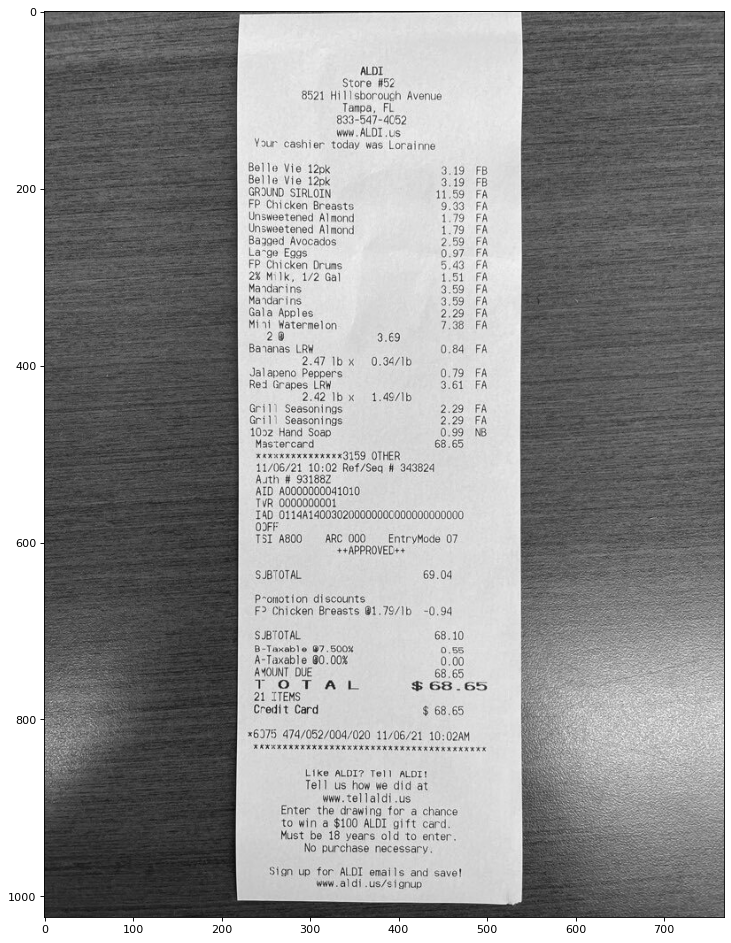

In [81]:
thresh = thresholding(gray, which = 'simple', thresh_hold=130)
# thresh = thresholding(gray, which = 'adaptive', thresh_hold=150)
show_cvimg(gray)

In [87]:
image = cv2.imread('receipt.JPG')
parsed, not_parsed = parse_receipt(image
#                                    , which='simple', thresh_hold=180
                                  )
parsed

item  price type
0       Belle Vie 12pk   3.19   FB
1       Belle Vie 12pk   3.19   FB
2       GROUND SIRLOIN  11.59   FA
3   FP Chicken Breasts   9733   FA
4      Baaged Avocados   2.59   FA
5     FP Chicken Drums   5.43   FA
6     28 W 1k, 1/2 Gal    151   FA
7            Hardarins   3.59   FA
8            Mardarins   3.59   FA
9          Gala Apples   2.29   FA
10     Mint Wateraeton    138   FA
11         Bananas LRW   0.84   FA
12   Jalapeno Peppers:   0.79   FA
13      Red Grapes LRW   3.61   FA
14     Sei" Seasonings   2.29   FA

In [57]:
image = cv2.imread('receipt.JPG')
gray = get_grayscale(image)
cv2.imshow("gray", gray)
cv2.waitKey()

32

In [59]:
thresh1 = thresholding(gray, thresh_hold=255)
cv2.imshow("gray", thresh1)
cv2.waitKey()

32

In [ ]:
#-----Reading the image-----------------------------------------------------
img = cv2.imread('Dog.jpg', 1)
cv2.imshow("img",img) 

#-----Converting image to LAB Color model----------------------------------- 
lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
cv2.imshow("lab",lab)

#-----Splitting the LAB image to different channels-------------------------
l, a, b = cv2.split(lab)
cv2.imshow('l_channel', l)
cv2.imshow('a_channel', a)
cv2.imshow('b_channel', b)

#-----Applying CLAHE to L-channel-------------------------------------------
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
cl = clahe.apply(l)
cv2.imshow('CLAHE output', cl)

#-----Merge the CLAHE enhanced L-channel with the a and b channel-----------
limg = cv2.merge((cl,a,b))
cv2.imshow('limg', limg)

#-----Converting image from LAB Color model to RGB model--------------------
final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
cv2.imshow('final', final)

In [28]:
iface = gr.Interface(fn=parse_receipt, inputs="image", outputs=["dataframe", "dataframe"])
iface.launch()


We want to invite you to become a beta user.
You'll get early access to new and premium features (persistent links, hosting, and more).
If you're interested please email: beta@gradio.app

Running on local URL:  http://127.0.0.1:7865/

To create a public link, set `share=True` in `launch()`.


(<Flask 'gradio.networking'>, 'http://127.0.0.1:7865/', None)